# MNIST TensorFlow dataset analysis

Making neural network using TensorFlow lower level API for a better understanding of how neural nets function under the hood.

In [121]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
#Data parameters
numClasses = 10 # total classes (0-9)
numFeatures = 784 # data features img shape 28 * 28

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Converting to float 32
X_train, X_test = np.array(X_train, np.float32), np.array(X_test, np.float32)
# Flattening the images to 1D vector
X_train, X_test = X_train.reshape([-1, numFeatures]), X_test.reshape([-1, numFeatures])
# Normalizing images 
X_train, X_test = X_train / 255 , X_test / 255

### Sampling data

In [3]:
import matplotlib.pyplot as plt

def displaySample(n):
    # print sample
    label = y_train[n]
    
    # Reshaping
    image = X_train[n].reshape([28,28])
    plt.title(f"Sample: {n}, Label: {label}")
    plt.imshow(image)
    plt.show()

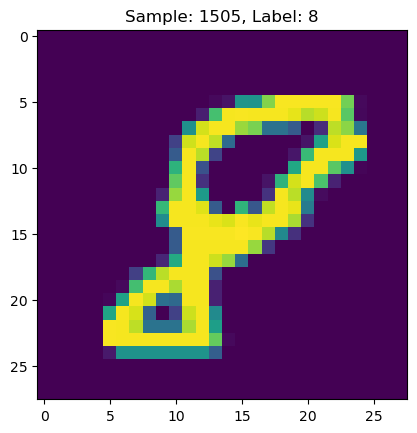

In [16]:
k = np.random.randint(2000)
k
displaySample(k)

### Viewing the training data

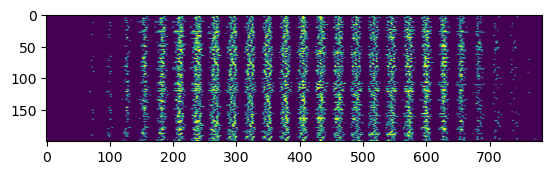

In [20]:
images = X_train[0].reshape([1, 784])
for i in range(1, 200):
    images = np.concatenate((images, X_train[i].reshape([1,784])))
plt.imshow(images)
plt.show()

### Training Parameters

In [55]:
learningRate = 0.005
trainingSteps = 3000
batchSize = 500
displayStep = 100

# Number of neurons 
nHidden = 512

In [24]:
trainData = tf.data.Dataset.from_tensor_slices((X_train, y_train))
trainData = trainData.repeat().shuffle(60_000).batch(batchSize).prefetch(1)

In [56]:
# Storing the weights and biases 

randomNormal = tf.initializers.RandomNormal()

weights = {
    'w': tf.Variable(randomNormal([numFeatures, nHidden])),
    'out' : tf.Variable(randomNormal([nHidden, numClasses]))
}
biases = {
    'b' : tf.Variable(tf.zeros([nHidden])),
    'out' : tf.Variable(tf.zeros([numClasses]))
}

## Creating Neural Net Model

In [59]:
def neuralNet(Data):
    # hidden layer of 512 neurons
    hiddenLayer = tf.add(tf.matmul(Data, weights['w']), biases['b'] )
    # Applying sigmoid function to hidden layer
    hiddenLayer = tf.nn.sigmoid(hiddenLayer)
    
    # Outputting with a neuron for each class
    outLayer = tf.matmul(hiddenLayer, weights['out']) + biases['out']
    # Applying softmax 
    return tf.nn.softmax(outLayer)
    

### Loss function

In [29]:
def crossEntropy(y_pred, y_true):
    # Entropy lable is a one-hot vector
    y_true = tf.one_hot(y_true, depth = numClasses)
    # Cllip prediction values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1,)
    # Computing cross entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

### Optimizer

In [30]:
optimizer = tf.keras.optimizers.SGD(learningRate)

def runOptimizer(x, y):
    # inside a gradient tape for automatic differentiation
    with tf.GradientTape() as g:
        pred = neuralNet(x)
        loss = crossEntropy(pred, y)
    
    # Variable to update, i.e trainable variables 
    trainableVariables = list(weights.values()) + list(biases.values())
    
    # Compute gradients
    gradients =  g.gradient(loss, trainableVariables)
    
    # Update w and b 
    optimizer.apply_gradients(zip(gradients, trainableVariables))

### *Accuracy*

In [37]:
def accuracy(y_pred, y_true):
    # highest core in prediciton vector (argmax) 
    correctPredicton = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64) )
    return tf.reduce_mean(tf.cast(correctPredicton, tf.float32), axis = -1)

### Training

In [60]:
for step, (batch_x, batch_y) in enumerate(trainData.take(trainingSteps), 1):
    # Run the optimization to update values of w and b
    runOptimizer(batch_x, batch_y)
    
    if step % displayStep == 0:
        pred = neuralNet(batch_x)
        loss = crossEntropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"Training epoch: {step}, Loss: {loss}, Accuracy: {acc}")

Training epoch: 100, Loss: 177.37396240234375, Accuracy: 0.7799999713897705
Training epoch: 200, Loss: 112.32460021972656, Accuracy: 0.8999999761581421
Training epoch: 300, Loss: 98.39510345458984, Accuracy: 0.9079999923706055
Training epoch: 400, Loss: 97.39836883544922, Accuracy: 0.8880000114440918
Training epoch: 500, Loss: 73.40277099609375, Accuracy: 0.9160000085830688
Training epoch: 600, Loss: 92.24034881591797, Accuracy: 0.9079999923706055
Training epoch: 700, Loss: 79.132080078125, Accuracy: 0.9120000004768372
Training epoch: 800, Loss: 81.50721740722656, Accuracy: 0.9160000085830688
Training epoch: 900, Loss: 94.46829986572266, Accuracy: 0.8999999761581421
Training epoch: 1000, Loss: 64.50238037109375, Accuracy: 0.9279999732971191
Training epoch: 1100, Loss: 66.17000579833984, Accuracy: 0.9279999732971191
Training epoch: 1200, Loss: 59.619869232177734, Accuracy: 0.9200000166893005
Training epoch: 1300, Loss: 82.69561767578125, Accuracy: 0.8960000276565552
Training epoch: 1400

### Testing model on validation dataset

In [61]:
pred = neuralNet(X_test)
print("Test Accuracy: ", accuracy(pred, y_test))

Test Accuracy:  tf.Tensor(0.9327, shape=(), dtype=float32)


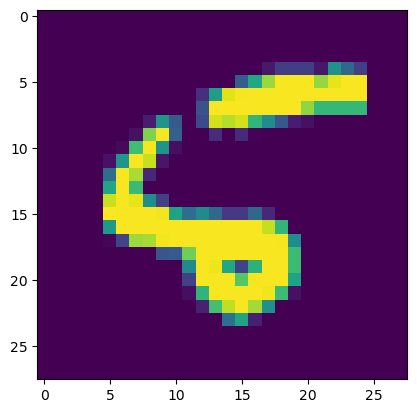

True Labels: 5
Model Prediction: 6


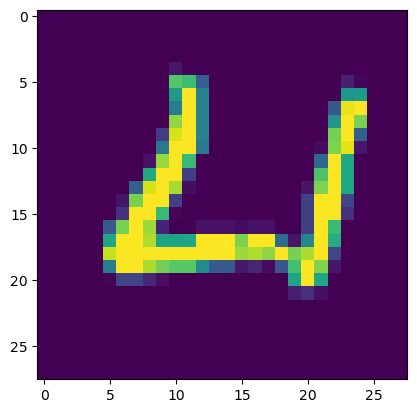

True Labels: 4
Model Prediction: 6


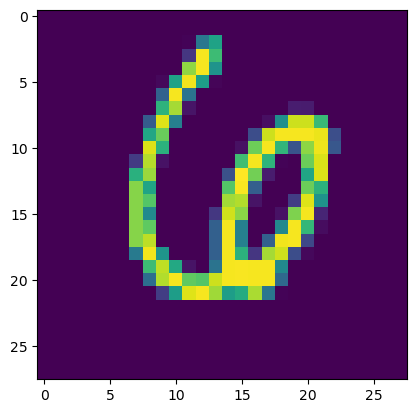

True Labels: 6
Model Prediction: 7


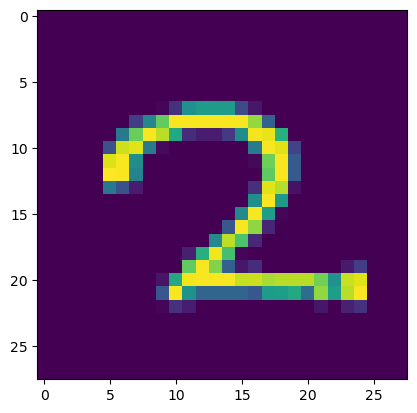

True Labels: 2
Model Prediction: 7


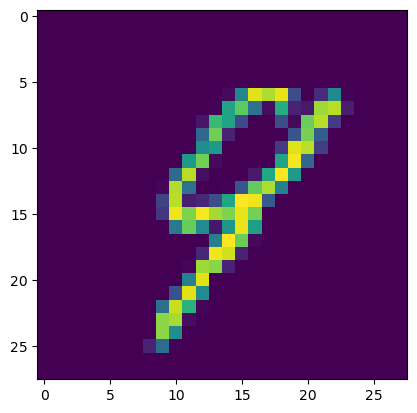

True Labels: 9
Model Prediction: 4


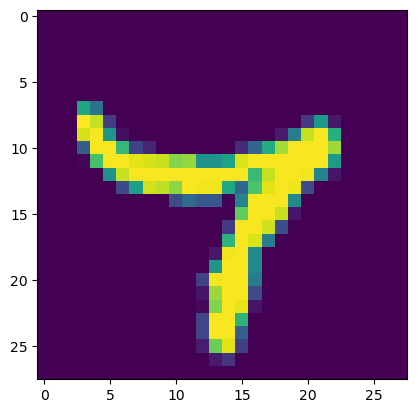

True Labels: 7
Model Prediction: 4


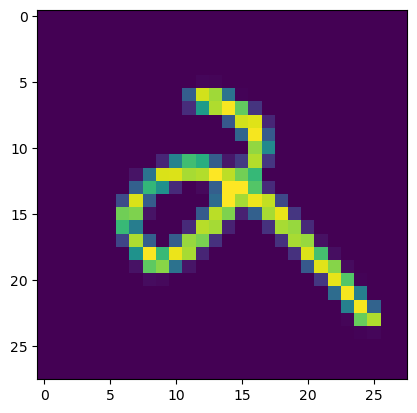

True Labels: 2
Model Prediction: 9


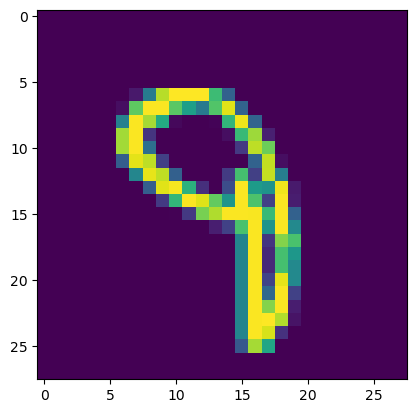

True Labels: 9
Model Prediction: 3


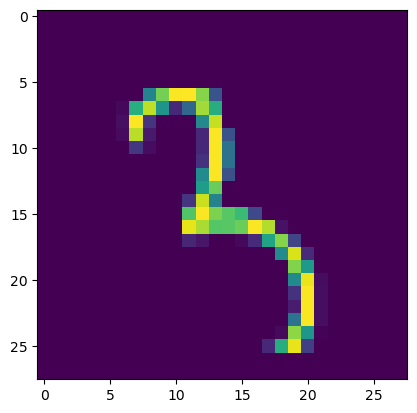

True Labels: 3
Model Prediction: 5


In [122]:
n_images = 200
test_images = X_test[:n_images]
test_labels = y_test[:n_images]
predictions = neuralNet(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28,28] ))
        plt.show()
        print(f"True Labels: {test_labels[i]}")
        print(f"Model Prediction: {model_prediction}")

### Testing with Keras and comparing the two models

In [86]:
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras import metrics

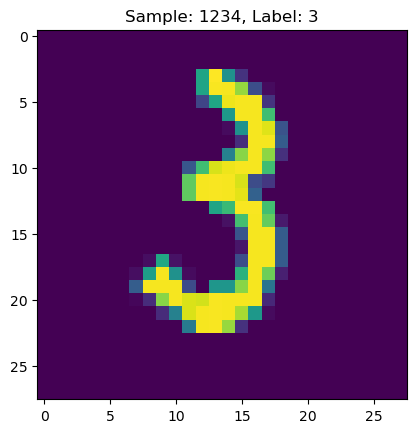

In [70]:
displaySample(1234)

In [71]:
model = Sequential()
model.add(Dense(512, activation = 'relu', input_shape=(784,)))
model.add(Dense(10, activation = 'softmax'))

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [141]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Flattening the images to 1D vector
X_train, X_test = X_train.reshape([60_000, 784]), X_test.reshape([10_000, 784])
# Converting to float 32
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
# Normalizing images 
X_train, X_test = X_train / 255 , X_test / 255

In [142]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [160]:
from tensorflow.keras.metrics import Accuracy

model.compile(loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [161]:
history = model.fit(X_train, 
                    y_train,
                    batch_size = 128, 
                    epochs = 12, 
                    validation_data = (X_test, y_test)
                   )

Epoch 1/12
469/469 [==============================] - 4s 7ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0844 - val_accuracy: 0.9819
Epoch 2/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0815 - val_accuracy: 0.9814
Epoch 3/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0891 - val_accuracy: 0.9816
Epoch 4/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0833 - val_accuracy: 0.9824
Epoch 5/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0903 - val_accuracy: 0.9825
Epoch 6/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0871 - val_accuracy: 0.9833
Epoch 7/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0967 - val_accuracy: 0.9810
Epoch 

In [164]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test Loss:", score [0])
print("Test Accuracy:", score[1])

Test Loss: 0.10739456862211227
Test Accuracy: 0.9819999933242798
